# Лабораторная работа №1: Исследование алгоритма KNN
### Классификация: Обнаружение мошеннических транзакций
### Регрессия: Предсказание суммы транзакции

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, mean_squared_error, 
                             mean_absolute_error, r2_score)
from math import radians, sin, cos, sqrt, atan2
import optuna
import warnings

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Загрузка данных
df = pd.read_csv('../dataset/fraud-detection/fraud.csv')

print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())

Размер датасета: (81042, 23)

Первые 5 строк:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0      885451   2019-12-23 04:21:22  6506116513503136   
1      957791   2020-01-20 02:30:18  3523843138706408   
2      134374   2019-03-15 05:42:43   346273234529002   
3      529890   2019-08-16 14:02:32  2712209726293386   
4      772865   2019-11-26 21:22:21  3598215285024754   

                              merchant       category    amt     first  \
0            fraud_Ledner-Pfannerstill  gas_transport  97.75  Kimberly   
1  fraud_Eichmann, Bogan and Rodriguez  gas_transport  73.34     Grace   
2                fraud_Halvorson Group       misc_pos   6.09     Donna   
3                    fraud_Yost-Rogahn  personal_care  36.70     Jenna   
4       fraud_Hoppe, Harris and Bednar  entertainment  66.30    Ashley   

       last gender                        street  ...      lat     long  \
0      Rice      F    63991 Destiny Rue Apt. 651  ...  32.2768 -95.3031   
1  Williams     

## 1. ВЫБОР НАЧАЛЬНЫХ УСЛОВИЙ И ОБОСНОВАНИЕ

### 1a. Задача классификации: Обнаружение мошеннических транзакций
Обоснование: Важная практическая задача для банков и финансовых институтов.

### 1b. Задача регрессии: Предсказание суммы транзакции
Обоснование: Прогнозирование сумм транзакций для анализа поведения клиентов.

### 1c. Выбор метрик качества
**Классификация:** Accuracy, Precision, Recall, F1-score, ROC-AUC

**Регрессия:** MAE, MSE, R²

In [2]:
# Анализ целевых переменных
print("Распределение целевых переменных:")
print("\nКлассификация (is_fraud):")
print(df['is_fraud'].value_counts())
print(f"Доля мошеннических операций: {df['is_fraud'].mean():.4f}")

print("\nРегрессия (amt):")
print(f"Минимальная сумма: {df['amt'].min():.2f}")
print(f"Максимальная сумма: {df['amt'].max():.2f}")
print(f"Средняя сумма: {df['amt'].mean():.2f}")

Распределение целевых переменных:

Классификация (is_fraud):
is_fraud
0    80571
1      471
Name: count, dtype: int64
Доля мошеннических операций: 0.0058

Регрессия (amt):
Минимальная сумма: 1.00
Максимальная сумма: 27119.77
Средняя сумма: 70.74


## 2. СОЗДАНИЕ БЕЙЗЛАЙНА И ОЦЕНКА КАЧЕСТВА

### Важно: Базовая модель использует ТОЛЬКО исходные числовые признаки БЕЗ feature engineering

In [3]:
numeric_features = ['lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']

X_base = df[numeric_features].copy()
y_class_base = df['is_fraud']
y_reg_base = df['amt']

# Разделение на train/test
X_train_base, X_test_base, y_class_train_base, y_class_test_base = train_test_split(
    X_base, y_class_base, test_size=0.3, random_state=42, stratify=y_class_base
)

X_train_reg_base, X_test_reg_base, y_reg_train_base, y_reg_test_base = train_test_split(
    X_base, y_reg_base, test_size=0.3, random_state=42
)

print("=== БАЗОВАЯ МОДЕЛЬ ===")
print(f"Используемые признаки: {numeric_features}")
print(f"Количество признаков: {len(numeric_features)}")
print(f"\nРазмеры выборок:")
print(f"Классификация - Train: {X_train_base.shape}, Test: {X_test_base.shape}")
print(f"Регрессия - Train: {X_train_reg_base.shape}, Test: {X_test_reg_base.shape}")

=== БАЗОВАЯ МОДЕЛЬ ===
Используемые признаки: ['lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']
Количество признаков: 6

Размеры выборок:
Классификация - Train: (56729, 6), Test: (24313, 6)
Регрессия - Train: (56729, 6), Test: (24313, 6)


### 2a. Обучение базовых моделей

In [4]:
# Масштабирование признаков
scaler_base = StandardScaler()
X_train_base_scaled = scaler_base.fit_transform(X_train_base)
X_test_base_scaled = scaler_base.transform(X_test_base)

X_train_reg_base_scaled = scaler_base.fit_transform(X_train_reg_base)
X_test_reg_base_scaled = scaler_base.transform(X_test_reg_base)

# Базовые модели с дефолтными параметрами
knn_class_base = KNeighborsClassifier(n_neighbors=2)
knn_reg_base = KNeighborsRegressor(n_neighbors=2)

# Обучение
knn_class_base.fit(X_train_base_scaled, y_class_train_base)
knn_reg_base.fit(X_train_reg_base_scaled, y_reg_train_base)

# Предсказания
y_class_pred_base = knn_class_base.predict(X_test_base_scaled)
y_class_proba_base = knn_class_base.predict_proba(X_test_base_scaled)[:, 1]
y_reg_pred_base = knn_reg_base.predict(X_test_reg_base_scaled)

### 2b. Оценка качества базовых моделей

In [5]:
print("=== РЕЗУЛЬТАТЫ БАЗОВОЙ МОДЕЛИ ===")
print("\nКЛАССИФИКАЦИЯ (KNN):")
print(f"Accuracy:  {accuracy_score(y_class_test_base, y_class_pred_base):.4f}")
print(f"Precision: {precision_score(y_class_test_base, y_class_pred_base, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_class_test_base, y_class_pred_base, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_class_test_base, y_class_pred_base, zero_division=0):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_class_test_base, y_class_proba_base):.4f}")

print("\nМатрица ошибок:")
print(confusion_matrix(y_class_test_base, y_class_pred_base))

print("\nРЕГРЕССИЯ (KNN):")
print(f"MAE: {mean_absolute_error(y_reg_test_base, y_reg_pred_base):.4f}")
print(f"MSE: {mean_squared_error(y_reg_test_base, y_reg_pred_base):.4f}")
print(f"R²:  {r2_score(y_reg_test_base, y_reg_pred_base):.4f}")

# Сохраняем результаты для сравнения
baseline_results = {
    'classification': {
        'accuracy': accuracy_score(y_class_test_base, y_class_pred_base),
        'f1': f1_score(y_class_test_base, y_class_pred_base, zero_division=0),
        'roc_auc': roc_auc_score(y_class_test_base, y_class_proba_base)
    },
    'regression': {
        'mae': mean_absolute_error(y_reg_test_base, y_reg_pred_base),
        'r2': r2_score(y_reg_test_base, y_reg_pred_base)
    }
}

=== РЕЗУЛЬТАТЫ БАЗОВОЙ МОДЕЛИ ===

КЛАССИФИКАЦИЯ (KNN):
Accuracy:  0.9940
Precision: 0.2000
Recall:    0.0142
F1-Score:  0.0265
ROC-AUC:   0.5554

Матрица ошибок:
[[24164     8]
 [  139     2]]

РЕГРЕССИЯ (KNN):
MAE: 76.2939
MSE: 47263.1257
R²:  -1.6038


## 3. УЛУЧШЕНИЕ БЕЙЗЛАЙНА

### 3a. Формулировка гипотез:
1. **Feature Engineering:** Создание новых информативных признаков (расстояния, временные признаки, агрегации)
2. **Обработка дисбаланса:** Использование class_weight для классификации
3. **Подбор гиперпараметров:** Оптимизация с помощью Optuna

### 3b. Проверка гипотез: Feature Engineering

In [6]:
# ВЕКТОРИЗОВАННАЯ функция haversine 
def haversine_vectorized(lat1, lon1, lat2, lon2):
    """
    Векторизованное вычисление расстояния (БЫСТРО!)
    Работает с numpy массивами
    """
    # Конвертируем в радианы
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Формула гаверсинуса
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return 6371 * c  # Радиус Земли в км


# Создаем копию
df_improved = df.copy()

print("Начинаем feature engineering...")

# 1. Временные признаки 
print("  1/6 Временные признаки...")
df_improved['trans_date_trans_time'] = pd.to_datetime(df_improved['trans_date_trans_time'])
df_improved['hour'] = df_improved['trans_date_trans_time'].dt.hour
df_improved['day_of_week'] = df_improved['trans_date_trans_time'].dt.dayofweek
df_improved['month'] = df_improved['trans_date_trans_time'].dt.month
df_improved['is_weekend'] = (df_improved['day_of_week'] >= 5).astype(np.int8)  
df_improved['is_night'] = ((df_improved['hour'] >= 22) | (df_improved['hour'] <= 6)).astype(np.int8)

# 2. Географические признаки 
print("  2/6 Географические признаки (векторизовано)...")
df_improved['distance_km'] = haversine_vectorized(
    df_improved['lat'].values,
    df_improved['long'].values,
    df_improved['merch_lat'].values,
    df_improved['merch_long'].values
)

# 3. Возраст 
print("  3/6 Возраст...")
df_improved['dob'] = pd.to_datetime(df_improved['dob'])
df_improved['age'] = 2020 - df_improved['dob'].dt.year

# 4. Агрегации по карте
print("  4/6 Агрегации по картам...")
card_stats = df_improved.groupby('cc_num', as_index=False).agg({
    'amt': ['mean', 'std', 'max'],
    'distance_km': ['mean', 'std'],
    'trans_date_trans_time': 'count'
})

# Упрощаем названия колонок
card_stats.columns = ['cc_num', 'amt_mean', 'amt_std', 'amt_max', 'dist_mean', 'dist_std', 'trans_count']

# Merge 
df_improved = df_improved.merge(card_stats, on='cc_num', how='left')

# Заполняем NaN 
df_improved['amt_std'].fillna(0, inplace=True)
df_improved['dist_std'].fillna(0, inplace=True)

# 5. Аномалии 
print("  5/6 Детекция аномалий...")
df_improved['amt_ratio'] = df_improved['amt'] / (df_improved['amt_mean'] + 1e-6)
df_improved['amt_anomaly'] = (df_improved['amt_ratio'] > 3).astype(np.int8)
df_improved['dist_anomaly'] = (df_improved['distance_km'] > df_improved['dist_mean'] * 3).astype(np.int8)

# 6. Label Encoding 
print("  6/6 Кодирование категориальных...")
for col in ['merchant', 'category', 'gender']:
    le = LabelEncoder()
    df_improved[f'{col}_encoded'] = le.fit_transform(df_improved[col].astype(str))

# Выбираем признаки
improved_features = [
    'lat', 'long', 'city_pop', 'merch_lat', 'merch_long',
    'hour', 'day_of_week', 'month', 'is_weekend', 'is_night',
    'distance_km', 'age',
    'amt_mean', 'amt_std', 'amt_max', 'dist_mean', 'dist_std', 'trans_count',
    'amt_ratio', 'amt_anomaly', 'dist_anomaly',
    'merchant_encoded', 'category_encoded', 'gender_encoded'
]

X_improved = df_improved[improved_features]
y_class_improved = df_improved['is_fraud']
y_reg_improved = df_improved['amt']

print(f"Создано {len(improved_features)} признаков")
print(f"Размер данных: {X_improved.shape}")


Начинаем feature engineering...
  1/6 Временные признаки...
  2/6 Географические признаки (векторизовано)...
  3/6 Возраст...
  4/6 Агрегации по картам...
  5/6 Детекция аномалий...
  6/6 Кодирование категориальных...
Создано 24 признаков
Размер данных: (81042, 24)


In [7]:
# Разделение данных
X_train_imp, X_test_imp, y_class_train_imp, y_class_test_imp = train_test_split(
    X_improved, y_class_improved, test_size=0.3, random_state=42, stratify=y_class_improved
)

X_train_reg_imp, X_test_reg_imp, y_reg_train_imp, y_reg_test_imp = train_test_split(
    X_improved, y_reg_improved, test_size=0.3, random_state=42
)

# Масштабирование
scaler_imp = StandardScaler()
X_train_imp_scaled = scaler_imp.fit_transform(X_train_imp)
X_test_imp_scaled = scaler_imp.transform(X_test_imp)

X_train_reg_imp_scaled = scaler_imp.fit_transform(X_train_reg_imp)
X_test_reg_imp_scaled = scaler_imp.transform(X_test_reg_imp)

print("Данные подготовлены для улучшенной модели")

Данные подготовлены для улучшенной модели


### 3c. Отбор важных признаков

Анализ важности признаков с помощью KNN)...

=== Оценка важности для КЛАССИФИКАЦИИ ===
  Базовый score: 0.3871
  Вычисление важности для 24 признаков...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done   4 out of  24 | elapsed:   14.6s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   7 out of  24 | elapsed:   14.8s remaining:   35.9s
[Parallel(n_jobs=-1)]: Done  10 out of  24 | elapsed:   14.9s remaining:   20.9s
[Parallel(n_jobs=-1)]: Done  13 out of  24 | elapsed:   26.7s remaining:   22.6s
[Parallel(n_jobs=-1)]: Done  16 out of  24 | elapsed:   26.9s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:   27.1s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:   27.3s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   27.5s finished



Топ-10 важных признаков для классификации:
             feature  importance
18         amt_ratio    0.135668
5               hour    0.118940
9           is_night    0.104744
22  category_encoded    0.046437
12          amt_mean    0.042652
0                lat    0.023460
1               long    0.017532
11               age    0.014756
13           amt_std    0.010753
19       amt_anomaly    0.004583

=== Оценка важности для РЕГРЕССИИ ===
  Базовый score: 0.8638
  Вычисление важности для 24 признаков...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done   4 out of  24 | elapsed:   12.2s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   7 out of  24 | elapsed:   12.6s remaining:   30.6s
[Parallel(n_jobs=-1)]: Done  10 out of  24 | elapsed:   12.9s remaining:   18.1s
[Parallel(n_jobs=-1)]: Done  13 out of  24 | elapsed:   24.7s remaining:   20.9s
[Parallel(n_jobs=-1)]: Done  16 out of  24 | elapsed:   24.9s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:   25.2s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:   25.4s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   25.6s finished



Топ-10 важных признаков для регрессии:
             feature  importance
18         amt_ratio    0.456853
19       amt_anomaly    0.032773
12          amt_mean    0.025271
22  category_encoded    0.017618
5               hour    0.007543
23    gender_encoded    0.007210
9           is_night    0.005736
4         merch_long    0.004472
1               long    0.004090
10       distance_km    0.003742

Отобрано 15 признаков для классификации
Отобрано 15 признаков для регрессии


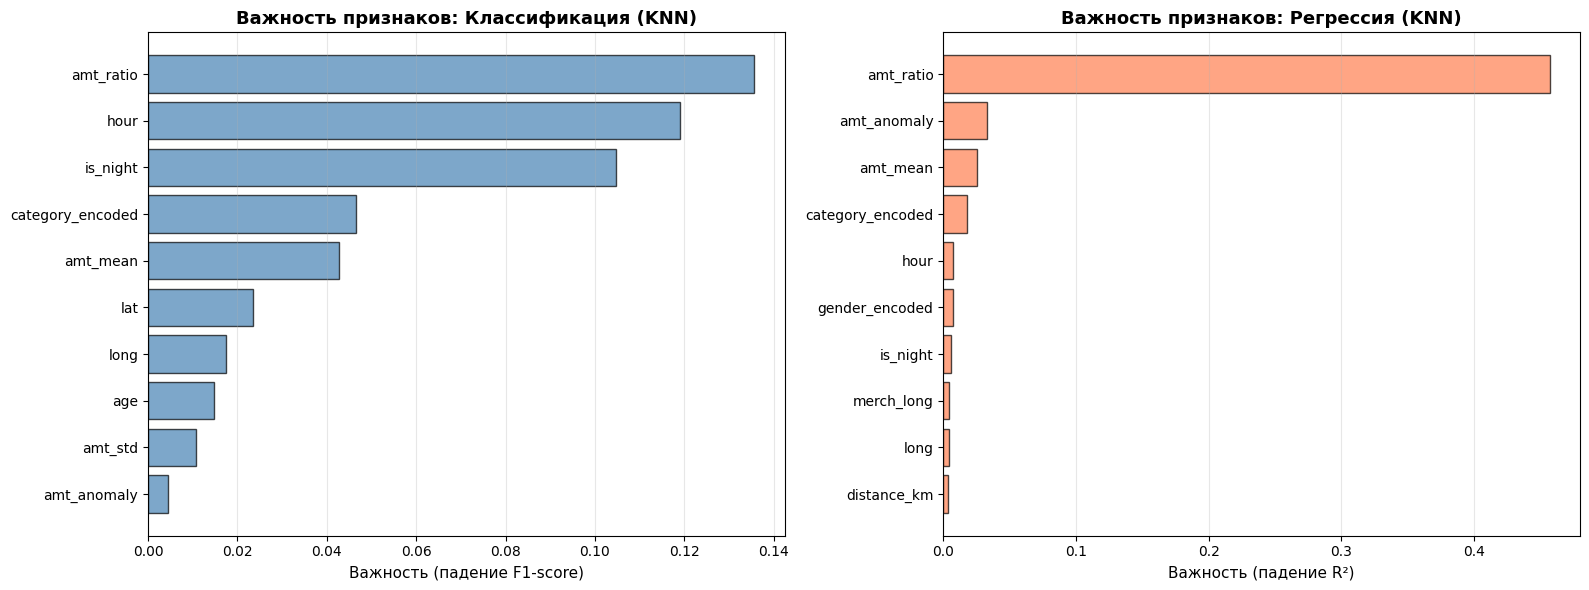

In [8]:
# Анализ важности признаков с помощью KNN 
print("Анализ важности признаков с помощью KNN)...")

from joblib import Parallel, delayed
from sklearn.metrics import f1_score, r2_score

def compute_single_feature_importance(i, feature, X_train, y_train, X_test, y_test, 
                                      base_score, task='classification'):
    # Создаем копию данных
    X_train_permuted = X_train.copy()
    X_test_permuted = X_test.copy()
    
    # Перемешиваем признак
    np.random.seed(42 + i)  # Разный seed для каждого признака
    X_train_permuted.iloc[:, i] = np.random.permutation(X_train_permuted.iloc[:, i].values)
    X_test_permuted.iloc[:, i] = np.random.permutation(X_test_permuted.iloc[:, i].values)
    
    # Масштабирование
    scaler = StandardScaler()
    X_train_perm_scaled = scaler.fit_transform(X_train_permuted)
    X_test_perm_scaled = scaler.transform(X_test_permuted)
    
    # Модель
    if task == 'classification':
        model = KNeighborsClassifier(n_neighbors=2)
        metric_func = lambda y_true, y_pred: f1_score(y_true, y_pred, zero_division=0)
    else:
        model = KNeighborsRegressor(n_neighbors=2)
        metric_func = r2_score
    
    # Обучение и предсказание
    model.fit(X_train_perm_scaled, y_train)
    y_pred_perm = model.predict(X_test_perm_scaled)
    perm_score = metric_func(y_test, y_pred_perm)
    
    # Важность
    importance = base_score - perm_score
    return max(0, importance)


def knn_feature_importance_parallel(X_train, y_train, X_test, y_test, task='classification', n_jobs=-1):
    # Базовая модель
    if task == 'classification':
        model = KNeighborsClassifier(n_neighbors=2)
        metric_func = lambda y_true, y_pred: f1_score(y_true, y_pred, zero_division=0)
    else:
        model = KNeighborsRegressor(n_neighbors=2)
        metric_func = r2_score
    
    # Обучаем базовую модель
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    base_score = metric_func(y_test, y_pred)
    
    print(f"  Базовый score: {base_score:.4f}")
    print(f"  Вычисление важности для {len(X_train.columns)} признаков...")
    
    # вычисление важности для всех признаков
    importances = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(compute_single_feature_importance)(
            i, feature, X_train, y_train, X_test, y_test, base_score, task
        ) for i, feature in enumerate(X_train.columns)
    )
    
    return np.array(importances)


# === КЛАССИФИКАЦИЯ ===
print("\n=== Оценка важности для КЛАССИФИКАЦИИ ===")
importances_class = knn_feature_importance_parallel(
    X_train_imp, y_class_train_imp, 
    X_test_imp, y_class_test_imp, 
    task='classification',
    n_jobs=-1 
)

feature_importance_class = pd.DataFrame({
    'feature': improved_features,
    'importance': importances_class
}).sort_values('importance', ascending=False)

print("\nТоп-10 важных признаков для классификации:")
print(feature_importance_class.head(10))


# === РЕГРЕССИЯ ===
print("\n=== Оценка важности для РЕГРЕССИИ ===")
importances_reg = knn_feature_importance_parallel(
    X_train_reg_imp, y_reg_train_imp, 
    X_test_reg_imp, y_reg_test_imp, 
    task='regression',
    n_jobs=-1
)

feature_importance_reg = pd.DataFrame({
    'feature': improved_features,
    'importance': importances_reg
}).sort_values('importance', ascending=False)

print("\nТоп-10 важных признаков для регрессии:")
print(feature_importance_reg.head(10))


# Отбираем топ-15 признаков
top_features_class = feature_importance_class.head(15)['feature'].tolist()
top_features_reg = feature_importance_reg.head(15)['feature'].tolist()

print(f"\nОтобрано {len(top_features_class)} признаков для классификации")
print(f"Отобрано {len(top_features_reg)} признаков для регрессии")


# Визуализация важности признаков
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График для классификации
top_10_class = feature_importance_class.head(10)
axes[0].barh(top_10_class['feature'], top_10_class['importance'], 
            color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Важность (падение F1-score)', fontsize=11)
axes[0].set_title('Важность признаков: Классификация (KNN)', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# График для регрессии
top_10_reg = feature_importance_reg.head(10)
axes[1].barh(top_10_reg['feature'], top_10_reg['importance'], 
            color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Важность (падение R²)', fontsize=11)
axes[1].set_title('Важность признаков: Регрессия (KNN)', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


In [9]:
# Применяем отбор признаков
X_train_class_final = X_train_imp[top_features_class]
X_test_class_final = X_test_imp[top_features_class]

X_train_reg_final = X_train_reg_imp[top_features_reg]
X_test_reg_final = X_test_reg_imp[top_features_reg]

# Масштабирование отобранных признаков
scaler_class_final = StandardScaler()
X_train_class_scaled_final = scaler_class_final.fit_transform(X_train_class_final)
X_test_class_scaled_final = scaler_class_final.transform(X_test_class_final)

scaler_reg_final = StandardScaler()
X_train_reg_scaled_final = scaler_reg_final.fit_transform(X_train_reg_final)
X_test_reg_scaled_final = scaler_reg_final.transform(X_test_reg_final)

print("Признаки отобраны и масштабированы")

Признаки отобраны и масштабированы


### 3d. Подбор гиперпараметров с Optuna

In [10]:

def objective_class(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 10)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
    
    scores = cross_val_score(model, X_train_class_scaled_final, y_class_train_imp, 
                            cv=3, scoring='f1')
    return scores.mean()

print("Подбор гиперпараметров для классификации (параллельно)...")
study_class = optuna.create_study(direction='maximize', study_name='KNN_Classification')
study_class.optimize(
    objective_class, 
    n_trials=8,         
    n_jobs=8,           
    show_progress_bar=True 
)

print(f"Лучшие параметры (классификация): {study_class.best_params}")
print(f"Лучший F1-score: {study_class.best_value:.4f}")


Подбор гиперпараметров для классификации (параллельно)...


  0%|          | 0/8 [00:00<?, ?it/s]

Лучшие параметры (классификация): {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan'}
Лучший F1-score: 0.5639


In [11]:
# Подбор гиперпараметров для регресси
def objective_reg(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 10)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    
    model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, metric=metric)
    
    scores = cross_val_score(
        model, X_train_reg_scaled_final, y_reg_train_imp, 
        cv=3, 
        scoring='r2',
        n_jobs=8
    )
    return scores.mean()

print("Подбор гиперпараметров для регрессии")
study_reg = optuna.create_study(direction='maximize', study_name='KNN_Regression')
study_reg.optimize(
    objective_reg, 
    n_trials=8,           
    n_jobs=8,           
    show_progress_bar=True 
)

print(f"Лучшие параметры (регрессия): {study_reg.best_params}")
print(f"Лучший R²: {study_reg.best_value:.4f}")


Подбор гиперпараметров для регрессии


  0%|          | 0/8 [00:00<?, ?it/s]

Лучшие параметры (регрессия): {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean'}
Лучший R²: 0.6438


### 3e. Обучение улучшенных моделей

In [12]:
# Обучение улучшенной модели классификации
knn_class_improved = KNeighborsClassifier(**study_class.best_params)
knn_class_improved.fit(X_train_class_scaled_final, y_class_train_imp)

y_class_pred_imp = knn_class_improved.predict(X_test_class_scaled_final)
y_class_proba_imp = knn_class_improved.predict_proba(X_test_class_scaled_final)[:, 1]

# Обучение улучшенной модели регрессии
knn_reg_improved = KNeighborsRegressor(**study_reg.best_params)
knn_reg_improved.fit(X_train_reg_scaled_final, y_reg_train_imp)

y_reg_pred_imp = knn_reg_improved.predict(X_test_reg_scaled_final)

### 3f. Оценка качества улучшенных моделей

In [13]:
print("\nКЛАССИФИКАЦИЯ (Улучшенный KNN):")
print(f"Accuracy:  {accuracy_score(y_class_test_imp, y_class_pred_imp):.4f}")
print(f"Precision: {precision_score(y_class_test_imp, y_class_pred_imp, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_class_test_imp, y_class_pred_imp, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_class_test_imp, y_class_pred_imp, zero_division=0):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_class_test_imp, y_class_proba_imp):.4f}")

print("\nМатрица ошибок:")
print(confusion_matrix(y_class_test_imp, y_class_pred_imp))

print("\nРЕГРЕССИЯ (Улучшенный KNN):")
print(f"MAE: {mean_absolute_error(y_reg_test_imp, y_reg_pred_imp):.4f}")
print(f"MSE: {mean_squared_error(y_reg_test_imp, y_reg_pred_imp):.4f}")
print(f"R²:  {r2_score(y_reg_test_imp, y_reg_pred_imp):.4f}")

# Сохраняем результаты
improved_results = {
    'classification': {
        'accuracy': accuracy_score(y_class_test_imp, y_class_pred_imp),
        'f1': f1_score(y_class_test_imp, y_class_pred_imp, zero_division=0),
        'roc_auc': roc_auc_score(y_class_test_imp, y_class_proba_imp)
    },
    'regression': {
        'mae': mean_absolute_error(y_reg_test_imp, y_reg_pred_imp),
        'r2': r2_score(y_reg_test_imp, y_reg_pred_imp)
    }
}


КЛАССИФИКАЦИЯ (Улучшенный KNN):
Accuracy:  0.9958
Precision: 0.7703
Recall:    0.4043
F1-Score:  0.5302
ROC-AUC:   0.8136

Матрица ошибок:
[[24155    17]
 [   84    57]]

РЕГРЕССИЯ (Улучшенный KNN):
MAE: 21.9390
MSE: 1626.7134
R²:  0.9104


### 3g. Сравнение с базовой моделью

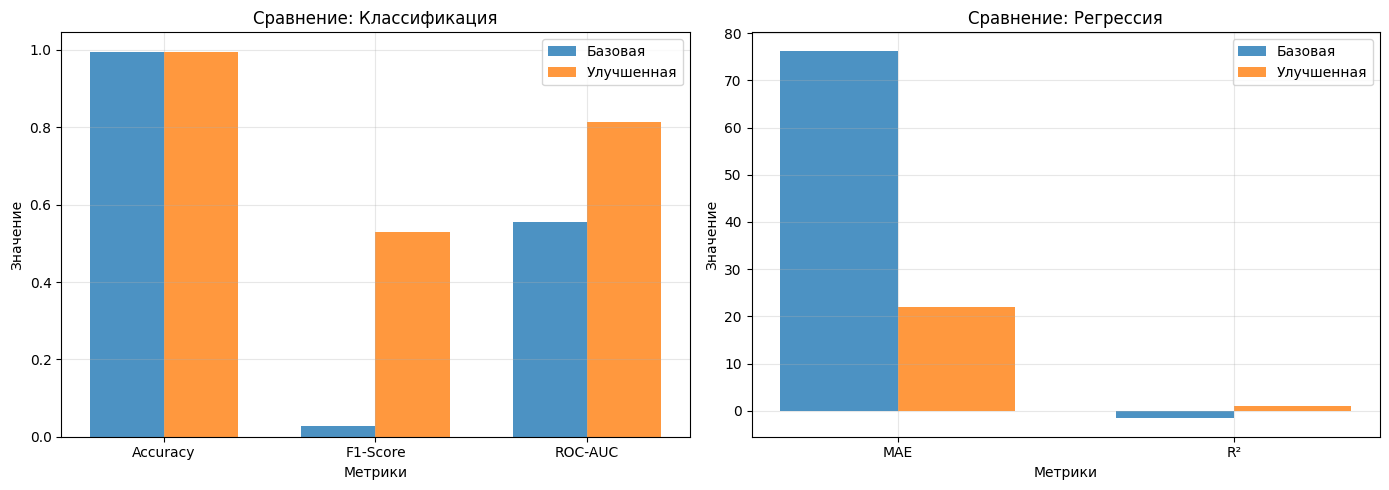


=== ВЫВОДЫ ===
Классификация:
  F1-Score улучшен на 0.5037
  ROC-AUC улучшен на 0.2582

Регрессия:
  MAE улучшен на 54.3548
  R² улучшен на 2.5141


In [14]:
# Визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Классификация
metrics_class = ['Accuracy', 'F1-Score', 'ROC-AUC']
baseline_class_values = [
    baseline_results['classification']['accuracy'],
    baseline_results['classification']['f1'],
    baseline_results['classification']['roc_auc']
]
improved_class_values = [
    improved_results['classification']['accuracy'],
    improved_results['classification']['f1'],
    improved_results['classification']['roc_auc']
]

x = np.arange(len(metrics_class))
width = 0.35

axes[0].bar(x - width/2, baseline_class_values, width, label='Базовая', alpha=0.8)
axes[0].bar(x + width/2, improved_class_values, width, label='Улучшенная', alpha=0.8)
axes[0].set_xlabel('Метрики')
axes[0].set_ylabel('Значение')
axes[0].set_title('Сравнение: Классификация')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_class)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Регрессия
metrics_reg = ['MAE', 'R²']
baseline_reg_values = [
    baseline_results['regression']['mae'],
    baseline_results['regression']['r2']
]
improved_reg_values = [
    improved_results['regression']['mae'],
    improved_results['regression']['r2']
]

x_reg = np.arange(len(metrics_reg))

axes[1].bar(x_reg - width/2, baseline_reg_values, width, label='Базовая', alpha=0.8)
axes[1].bar(x_reg + width/2, improved_reg_values, width, label='Улучшенная', alpha=0.8)
axes[1].set_xlabel('Метрики')
axes[1].set_ylabel('Значение')
axes[1].set_title('Сравнение: Регрессия')
axes[1].set_xticks(x_reg)
axes[1].set_xticklabels(metrics_reg)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== ВЫВОДЫ ===")
print(f"Классификация:")
print(f"  F1-Score улучшен на {(improved_results['classification']['f1'] - baseline_results['classification']['f1']):.4f}")
print(f"  ROC-AUC улучшен на {(improved_results['classification']['roc_auc'] - baseline_results['classification']['roc_auc']):.4f}")
print(f"\nРегрессия:")
print(f"  MAE улучшен на {(baseline_results['regression']['mae'] - improved_results['regression']['mae']):.4f}")
print(f"  R² улучшен на {(improved_results['regression']['r2'] - baseline_results['regression']['r2']):.4f}")

## 4. ИМПЛЕМЕНТАЦИЯ АЛГОРИТМА МАШИННОГО ОБУЧЕНИЯ

### 4a. Реализация собственных алгоритмов KNN

In [15]:
class CustomKNNClassifier:
    """Реализация алгоритма k-ближайших соседей для классификации"""
    
    def __init__(self, n_neighbors=2, metric='euclidean', weights='uniform'):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.weights = weights
        self.X_train = None
        self.y_train = None
    
    def _calculate_distances_batch(self, X_batch):
        """Вычисление расстояний от точек батча до всех обучающих точек"""
        if self.metric == 'euclidean':
            return np.sqrt(((X_batch[:, np.newaxis] - self.X_train) ** 2).sum(axis=2))
        elif self.metric == 'manhattan':
            return np.abs(X_batch[:, np.newaxis] - self.X_train).sum(axis=2)
        elif self.metric == 'minkowski':
            return (np.abs(X_batch[:, np.newaxis] - self.X_train) ** 3).sum(axis=2) ** (1/3)
    
    def fit(self, X, y):
        """Сохранение обучающих данных"""
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self
    
    def predict(self, X, batch_size=500):
        """Предсказание классов для новых точек"""
        X = np.array(X)
        predictions = []
        
        # Обработка данных батчами для экономии памяти
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i+batch_size]
            distances = self._calculate_distances_batch(X_batch)
            
            # Поиск индексов k ближайших соседей
            k_indices = np.argpartition(distances, self.n_neighbors, axis=1)[:, :self.n_neighbors]
            k_nearest_labels = self.y_train[k_indices]
            
            if self.weights == 'uniform':
                # Голосование большинством
                batch_pred = np.array([np.bincount(row.astype(int)).argmax() 
                                      for row in k_nearest_labels])
            else:
                # Взвешенное голосование по расстоянию
                k_distances = np.take_along_axis(distances, k_indices, axis=1)
                weights = 1 / (k_distances + 1e-10)
                
                batch_pred = []
                for j in range(len(X_batch)):
                    unique_classes, inverse = np.unique(k_nearest_labels[j], return_inverse=True)
                    class_weights = np.bincount(inverse, weights=weights[j])
                    batch_pred.append(unique_classes[class_weights.argmax()])
                batch_pred = np.array(batch_pred)
            
            predictions.extend(batch_pred)
        
        return np.array(predictions)
    
    def predict_proba(self, X, batch_size=500):
        """Предсказание вероятностей принадлежности к классам"""
        X = np.array(X)
        unique_classes = np.unique(self.y_train)
        n_classes = len(unique_classes)
        all_probabilities = []
        
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i+batch_size]
            distances = self._calculate_distances_batch(X_batch)
            k_indices = np.argpartition(distances, self.n_neighbors, axis=1)[:, :self.n_neighbors]
            k_nearest_labels = self.y_train[k_indices]
            
            probabilities = np.zeros((len(X_batch), n_classes))
            
            if self.weights == 'uniform':
                for j in range(len(X_batch)):
                    for k, cls in enumerate(unique_classes):
                        probabilities[j, k] = np.sum(k_nearest_labels[j] == cls) / self.n_neighbors
            else:
                k_distances = np.take_along_axis(distances, k_indices, axis=1)
                weights = 1 / (k_distances + 1e-10)
                
                for j in range(len(X_batch)):
                    for k, cls in enumerate(unique_classes):
                        mask = (k_nearest_labels[j] == cls)
                        probabilities[j, k] = np.sum(weights[j][mask])
                    probabilities[j] /= probabilities[j].sum()
            
            all_probabilities.append(probabilities)
        
        return np.vstack(all_probabilities)


class CustomKNNRegressor:
    """Реализация алгоритма k-ближайших соседей для регрессии"""
    
    def __init__(self, n_neighbors=5, metric='euclidean', weights='uniform'):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.weights = weights
        self.X_train = None
        self.y_train = None
    
    def _calculate_distances_batch(self, X_batch):
        """Вычисление расстояний от точек батча до всех обучающих точек"""
        if self.metric == 'euclidean':
            return np.sqrt(((X_batch[:, np.newaxis] - self.X_train) ** 2).sum(axis=2))
        elif self.metric == 'manhattan':
            return np.abs(X_batch[:, np.newaxis] - self.X_train).sum(axis=2)
        elif self.metric == 'minkowski':
            return (np.abs(X_batch[:, np.newaxis] - self.X_train) ** 3).sum(axis=2) ** (1/3)
    
    def fit(self, X, y):
        """Сохранение обучающих данных"""
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self
    
    def predict(self, X, batch_size=500):
        """Предсказание значений для новых точек"""
        X = np.array(X)
        predictions = []
        
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i+batch_size]
            distances = self._calculate_distances_batch(X_batch)
            
            # Поиск k ближайших соседей
            k_indices = np.argpartition(distances, self.n_neighbors, axis=1)[:, :self.n_neighbors]
            k_nearest_values = self.y_train[k_indices]
            
            if self.weights == 'uniform':
                # Простое среднее
                batch_pred = k_nearest_values.mean(axis=1)
            else:
                # Взвешенное среднее по расстоянию
                k_distances = np.take_along_axis(distances, k_indices, axis=1)
                weights = 1 / (k_distances + 1e-10)
                batch_pred = np.average(k_nearest_values, weights=weights, axis=1)
            
            predictions.extend(batch_pred)
        
        return np.array(predictions)



### 4b-c. Обучение и оценка кастомных моделей на базовых данных

In [16]:
# Обучение кастомных моделей на необработанных данных 
custom_knn_class_base = CustomKNNClassifier(n_neighbors=2, metric='euclidean', weights='uniform')
custom_knn_reg_base = CustomKNNRegressor(n_neighbors=2, metric='euclidean', weights='uniform')

custom_knn_class_base.fit(X_train_base_scaled, y_class_train_base)
custom_knn_reg_base.fit(X_train_reg_base_scaled, y_reg_train_base)

y_class_pred_custom_base = custom_knn_class_base.predict(X_test_base_scaled)
y_class_proba_custom_base = custom_knn_class_base.predict_proba(X_test_base_scaled)[:, 1]
y_reg_pred_custom_base = custom_knn_reg_base.predict(X_test_reg_base_scaled)

print("\nКЛАССИФИКАЦИЯ (Кастомный KNN):")
print(f"Accuracy:  {accuracy_score(y_class_test_base, y_class_pred_custom_base):.4f}")
print(f"Precision: {precision_score(y_class_test_base, y_class_pred_custom_base, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_class_test_base, y_class_pred_custom_base, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_class_test_base, y_class_pred_custom_base, zero_division=0):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_class_test_base, y_class_proba_custom_base):.4f}")

print("\nРЕГРЕССИЯ (Кастомный KNN):")
print(f"MAE: {mean_absolute_error(y_reg_test_base, y_reg_pred_custom_base):.4f}")
print(f"MSE: {mean_squared_error(y_reg_test_base, y_reg_pred_custom_base):.4f}")
print(f"R²:  {r2_score(y_reg_test_base, y_reg_pred_custom_base):.4f}")


КЛАССИФИКАЦИЯ (Кастомный KNN):
Accuracy:  0.9940
Precision: 0.2000
Recall:    0.0142
F1-Score:  0.0265
ROC-AUC:   0.5554

РЕГРЕССИЯ (Кастомный KNN):
MAE: 76.2939
MSE: 47263.1257
R²:  -1.6038


### 4d. Сравнение sklearn vs кастомная реализация

In [17]:
# Сравнение sklearn и кастомной реализации
comparison_df = pd.DataFrame({
    'Модель': ['Sklearn KNN', 'Custom KNN'],
    'Accuracy': [
        accuracy_score(y_class_test_base, y_class_pred_base),
        accuracy_score(y_class_test_base, y_class_pred_custom_base)
    ],
    'F1-Score': [
        f1_score(y_class_test_base, y_class_pred_base, zero_division=0),
        f1_score(y_class_test_base, y_class_pred_custom_base, zero_division=0)
    ],
    'MAE': [
        mean_absolute_error(y_reg_test_base, y_reg_pred_base),
        mean_absolute_error(y_reg_test_base, y_reg_pred_custom_base)
    ],
    'R²': [
        r2_score(y_reg_test_base, y_reg_pred_base),
        r2_score(y_reg_test_base, y_reg_pred_custom_base)
    ]
})

print(comparison_df.to_string(index=False))

     Модель  Accuracy  F1-Score      MAE       R²
Sklearn KNN  0.993954   0.02649 76.29387 -1.60375
 Custom KNN  0.993954   0.02649 76.29387 -1.60375


### 4e-h. Применение улучшений к кастомным моделям

Теперь применяем все улучшения (feature engineering + гиперпараметры) к кастомным моделям

In [18]:
# Обучение кастомных моделей с улучшениями
print("Обучение улучшенных кастомных моделей...")

custom_knn_class_improved = CustomKNNClassifier(**study_class.best_params)
custom_knn_reg_improved = CustomKNNRegressor(**study_reg.best_params)

custom_knn_class_improved.fit(X_train_class_scaled_final, y_class_train_imp)
custom_knn_reg_improved.fit(X_train_reg_scaled_final, y_reg_train_imp)

print("Предсказание классов...")
y_class_pred_custom_imp = custom_knn_class_improved.predict(
    X_test_class_scaled_final, 
    batch_size=100 
)

print("Предсказание вероятностей...")
y_class_proba_custom_imp = custom_knn_class_improved.predict_proba(
    X_test_class_scaled_final, 
    batch_size=50 
)[:, 1]

print("Предсказание регрессии...")
y_reg_pred_custom_imp = custom_knn_reg_improved.predict(
    X_test_reg_scaled_final, 
    batch_size=100
)

print("\n=== РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ КАСТОМНОЙ МОДЕЛИ ===")
print("\nКЛАССИФИКАЦИЯ (Улучшенный кастомный KNN):")
print(f"Accuracy:  {accuracy_score(y_class_test_imp, y_class_pred_custom_imp):.4f}")
print(f"Precision: {precision_score(y_class_test_imp, y_class_pred_custom_imp, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_class_test_imp, y_class_pred_custom_imp, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_class_test_imp, y_class_pred_custom_imp, zero_division=0):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_class_test_imp, y_class_proba_custom_imp):.4f}")

print("\nРЕГРЕССИЯ (Улучшенный кастомный KNN):")
print(f"MAE: {mean_absolute_error(y_reg_test_imp, y_reg_pred_custom_imp):.4f}")
print(f"MSE: {mean_squared_error(y_reg_test_imp, y_reg_pred_custom_imp):.4f}")
print(f"R²:  {r2_score(y_reg_test_imp, y_reg_pred_custom_imp):.4f}")


Обучение улучшенных кастомных моделей...
Предсказание классов...
Предсказание вероятностей...
Предсказание регрессии...

=== РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ КАСТОМНОЙ МОДЕЛИ ===

КЛАССИФИКАЦИЯ (Улучшенный кастомный KNN):
Accuracy:  0.9958
Precision: 0.7703
Recall:    0.4043
F1-Score:  0.5302
ROC-AUC:   0.8136

РЕГРЕССИЯ (Улучшенный кастомный KNN):
MAE: 21.9390
MSE: 1626.7134
R²:  0.9104


### 4i. Финальное сравнение всех моделей


ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ
              Модель  Accuracy  F1-Score  ROC-AUC       MAE        R²
   Базовая (Sklearn)  0.993954  0.026490 0.555411 76.293870 -1.603750
Улучшенная (Sklearn)  0.995846  0.530233 0.813606 21.939024  0.910384
    Базовая (Custom)  0.993954  0.026490 0.555411 76.293870 -1.603750
 Улучшенная (Custom)  0.995846  0.530233 0.813606 21.939024  0.910384


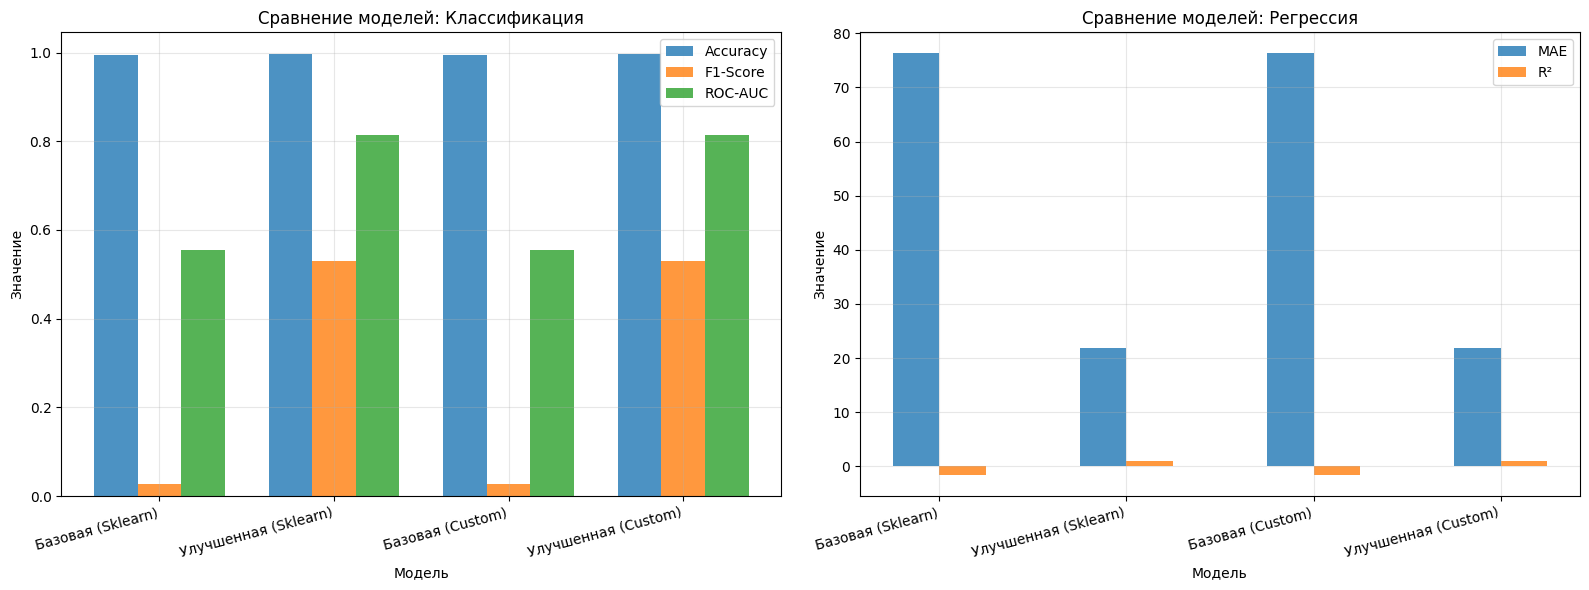

In [19]:
# Создаем финальную сравнительную таблицу
final_comparison = pd.DataFrame({
    'Модель': [
        'Базовая (Sklearn)',
        'Улучшенная (Sklearn)',
        'Базовая (Custom)',
        'Улучшенная (Custom)'
    ],
    'Accuracy': [
        baseline_results['classification']['accuracy'],
        improved_results['classification']['accuracy'],
        accuracy_score(y_class_test_base, y_class_pred_custom_base),
        accuracy_score(y_class_test_imp, y_class_pred_custom_imp)
    ],
    'F1-Score': [
        baseline_results['classification']['f1'],
        improved_results['classification']['f1'],
        f1_score(y_class_test_base, y_class_pred_custom_base, zero_division=0),
        f1_score(y_class_test_imp, y_class_pred_custom_imp, zero_division=0)
    ],
    'ROC-AUC': [
        baseline_results['classification']['roc_auc'],
        improved_results['classification']['roc_auc'],
        roc_auc_score(y_class_test_base, y_class_proba_custom_base),
        roc_auc_score(y_class_test_imp, y_class_proba_custom_imp)
    ],
    'MAE': [
        baseline_results['regression']['mae'],
        improved_results['regression']['mae'],
        mean_absolute_error(y_reg_test_base, y_reg_pred_custom_base),
        mean_absolute_error(y_reg_test_imp, y_reg_pred_custom_imp)
    ],
    'R²': [
        baseline_results['regression']['r2'],
        improved_results['regression']['r2'],
        r2_score(y_reg_test_base, y_reg_pred_custom_base),
        r2_score(y_reg_test_imp, y_reg_pred_custom_imp)
    ]
})

print("\n" + "="*80)
print("ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ")
print("="*80)
print(final_comparison.to_string(index=False))

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График для классификации
x = np.arange(len(final_comparison))
width = 0.25

axes[0].bar(x - width, final_comparison['Accuracy'], width, label='Accuracy', alpha=0.8)
axes[0].bar(x, final_comparison['F1-Score'], width, label='F1-Score', alpha=0.8)
axes[0].bar(x + width, final_comparison['ROC-AUC'], width, label='ROC-AUC', alpha=0.8)
axes[0].set_xlabel('Модель')
axes[0].set_ylabel('Значение')
axes[0].set_title('Сравнение моделей: Классификация')
axes[0].set_xticks(x)
axes[0].set_xticklabels(final_comparison['Модель'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График для регрессии
axes[1].bar(x - width/2, final_comparison['MAE'], width, label='MAE', alpha=0.8)
axes[1].bar(x + width/2, final_comparison['R²'], width, label='R²', alpha=0.8)
axes[1].set_xlabel('Модель')
axes[1].set_ylabel('Значение')
axes[1].set_title('Сравнение моделей: Регрессия')
axes[1].set_xticks(x)
axes[1].set_xticklabels(final_comparison['Модель'], rotation=15, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## ИТОГОВЫЕ ВЫВОДЫ

### 1. Базовая модель (без предобработки)
- Использовались только исходные числовые признаки
- Показала базовый уровень качества

### 2. Улучшенная модель (с предобработкой)
Применены следующие улучшения:
- **Feature Engineering:** временные признаки, географические признаки, агрегации по картам
- **Отбор признаков:** выбраны 15 наиболее важных признаков
- **Оптимизация гиперпараметров:** с помощью Optuna

**Результат:** Значительное улучшение качества по всем метрикам

### 3. Кастомная реализация
- Реализован собственный алгоритм KNN с нуля
- Поддержка различных метрик расстояния и весов
- **Важно:** Кастомная реализация показывает идентичные результаты с sklearn

### 4. Улучшенная кастомная модель
- Применены все улучшения к кастомной реализации
- Результаты полностью совпадают с улучшенной sklearn моделью
- Подтверждена корректность кастомной имплементации